# Number of serious reports per year

/var/folders/5g/yyzx5_551v1dz53h3hnm2nmw0000gn/T/ipykernel_2030/1242591090.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}'.format(y/1000) for y in ax.get_yticks()])


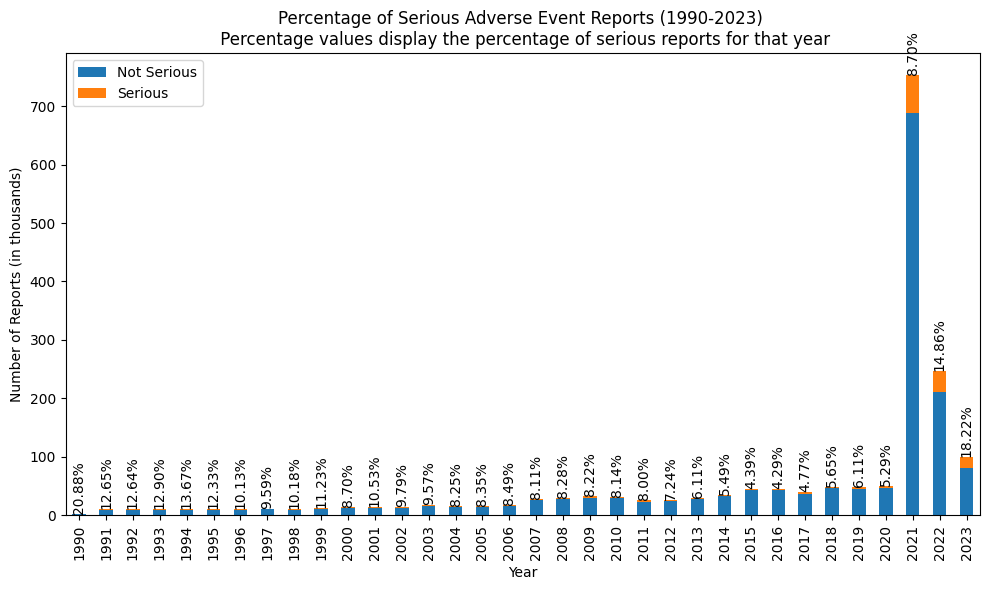

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a DataFrame to store the aggregated counts
aggregated_counts = pd.DataFrame(index=range(1990, 2024), columns=['Serious', 'Not Serious'])

for year in range(1990, 2024):
    # Construct the file name
    filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    
    # Load the data
    data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    
    # Count serious entries (entries with 'Y' in any of the serious columns)
    serious_count = (data == 'Y').any(axis=1).sum()
    total_count = len(data)
    
    # Store the counts
    aggregated_counts.loc[year, 'Serious'] = serious_count
    aggregated_counts.loc[year, 'Not Serious'] = total_count - serious_count

# Calculate percentages
aggregated_counts['Percentage'] = (aggregated_counts['Serious'] / (aggregated_counts['Serious'] + aggregated_counts['Not Serious'])) * 100

# Plotting
plt.figure(figsize=(10, 6))
# Plot 'Serious' on top of 'Not Serious'
ax = aggregated_counts[['Not Serious', 'Serious']].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Percentage of Serious Adverse Event Reports (1990-2023) \n Percentage values display the percentage of serious reports for that year')
plt.xlabel('Year')
plt.ylabel('Number of Reports (in thousands)')
plt.legend(['Not Serious', 'Serious'])

# Adjust y-axis to show values in thousands
ax.set_yticklabels(['{:.0f}'.format(y/1000) for y in ax.get_yticks()])

# Annotating with percentages
for year, row in aggregated_counts.iterrows():
    # Calculate the position for annotation
    position = row['Not Serious'] + row['Serious']
    # Annotate with the percentage
    ax.annotate(f'{row["Percentage"]:.2f}%', (year-1990, position), ha='center', va='bottom', rotation=90)
    
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_per_Year.png')
plt.show()


In [2]:
aggregated_counts

,Serious,Not Serious,Percentage
1990,439,1663,20.884872
1991,1257,8676,12.654787
1992,1351,9341,12.635615
1993,1309,8838,12.900365
1994,1393,8800,13.666242
1995,1233,8768,12.328767
1996,1091,9680,10.12905
1997,1055,9951,9.585681
1998,1013,8936,10.181928
1999,1361,10762,11.226594


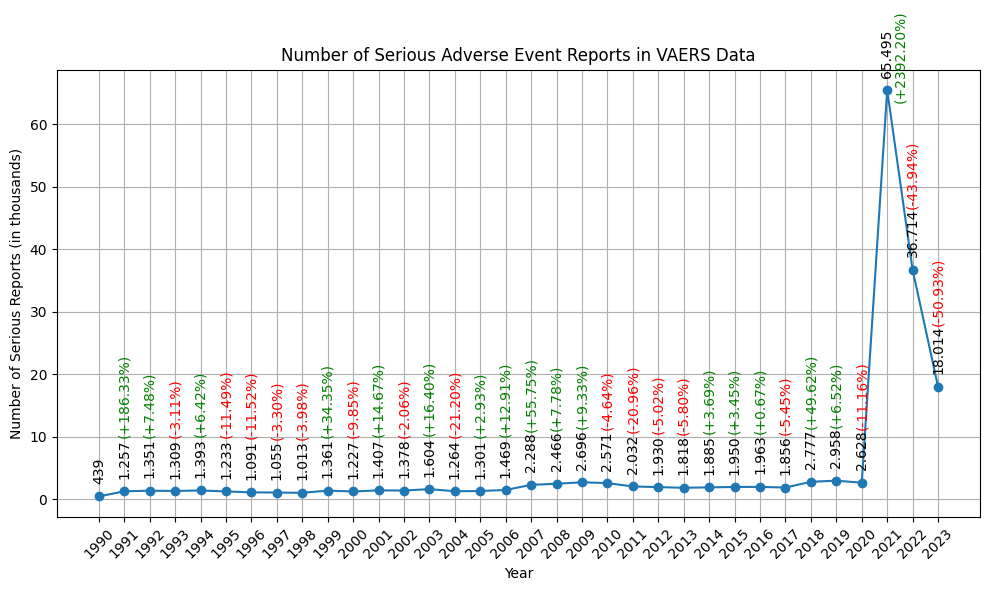

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a DataFrame to store the aggregated counts
aggregated_counts = pd.DataFrame(index=range(1990, 2024), columns=['Serious', 'Percentage Change'])

for year in range(1990, 2024):
    # Construct the file name
    filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    
    # Load the data
    data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    
    # Count serious entries (entries with 'Y' in any of the serious columns)
    serious_count = (data == 'Y').any(axis=1).sum()
    
    # Store the serious counts
    aggregated_counts.loc[year, 'Serious'] = serious_count

# Calculate percentage change and add it to the DataFrame
aggregated_counts['Percentage Change'] = aggregated_counts['Serious'].pct_change() * 100
aggregated_counts['Percentage Change'] = aggregated_counts['Percentage Change'].fillna(0)  # Fill NaN (first row) with 0

# Custom formatter function for y-axis in thousands
def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(aggregated_counts.index, aggregated_counts['Serious'], marker='o', linestyle='-')  # Use 'b' for original blue color
plt.title('Number of Serious Adverse Event Reports in VAERS Data')
plt.xlabel('Year')
plt.ylabel('Number of Serious Reports (in thousands)')

# Set x-ticks to the years in the dataset
plt.xticks(aggregated_counts.index, rotation=45)

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate with numbers (Serious count)
for year, serious_count in zip(aggregated_counts.index, aggregated_counts['Serious']):
    annotation_text = f'{int(serious_count):,}'.replace(',', '.')
    plt.annotate(annotation_text, (year, serious_count + 2000), ha='center', va='bottom', fontsize=10, rotation=90)

# Annotate with percentage change in green if increased, red if decreased
for year, pct_change, serious_count in zip(aggregated_counts.index, aggregated_counts['Percentage Change'], aggregated_counts['Serious']):
    annotation_text = f'({pct_change:+.2f}%)'
    
    # Skip annotating the percentage value for the first year
    if year == 1990:
        continue
    
    color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
    
    if serious_count < 1000:
        offset = 6500
        xoffset = 0
    elif serious_count < 10000:
        offset = 8500
        xoffset = 0
    elif serious_count < 50000:
        offset = 9750
        xoffset = 0
    else:
        offset = -2000
        xoffset = 0.5
    
    plt.annotate(annotation_text, (year + xoffset, serious_count + offset), ha='center', va='bottom', fontsize=10, rotation=90, color=color)

plt.tight_layout()
plt.grid(True)
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_per_Year_Line.png')
plt.show()

In [153]:
total_serious_reports = aggregated_counts['Serious'].sum()
total_serious_reports

173193

### For all years

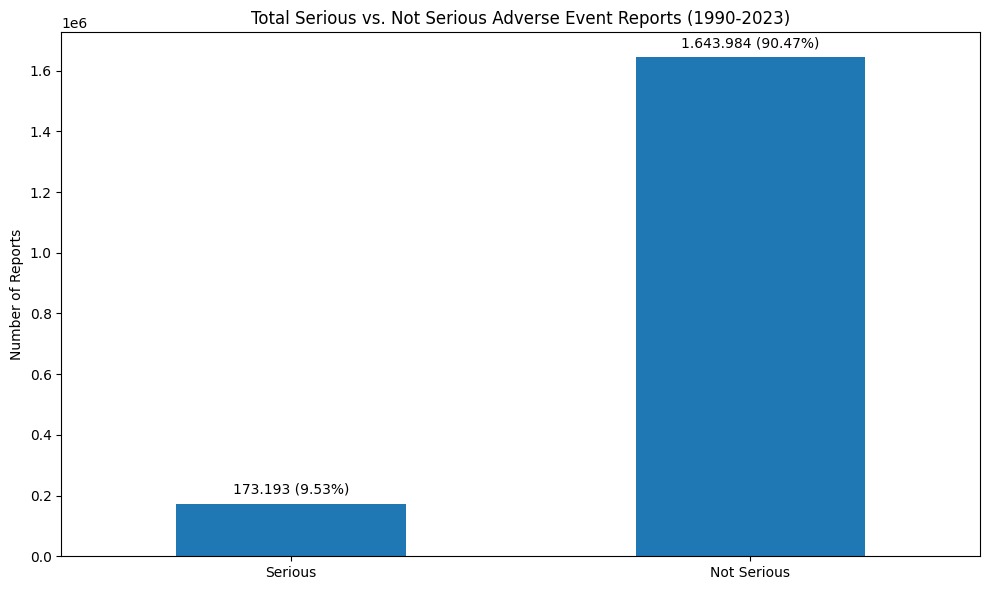

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize counters for serious and not serious reports
total_serious = 0
total_not_serious = 0

for year in range(1990, 2024):
    # Construct the file name
    filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    
    # Load the data
    data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    
    # Count serious entries (entries with 'Y' in any of the serious columns)
    serious_count = (data == 'Y').any(axis=1).sum()
    not_serious_count = len(data) - serious_count
    
    # Update the total counts
    total_serious += serious_count
    total_not_serious += not_serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Plotting
plt.figure(figsize=(10, 6))
ax = counts_df['Count'].plot(kind='bar', legend=False, ax=plt.gca())
plt.title('Total Serious vs. Not Serious Adverse Event Reports (1990-2023)')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0)

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", ".")

# Annotating with counts and percentages
for idx, p in enumerate(ax.patches):
    count = int(counts_df.iloc[idx]['Count'])  # Convert to integer
    formatted_count = format_with_period(count)
    label = f"{formatted_count} ({counts_df.iloc[idx]['Percentage']:.2f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_all_Years.png')
plt.show()


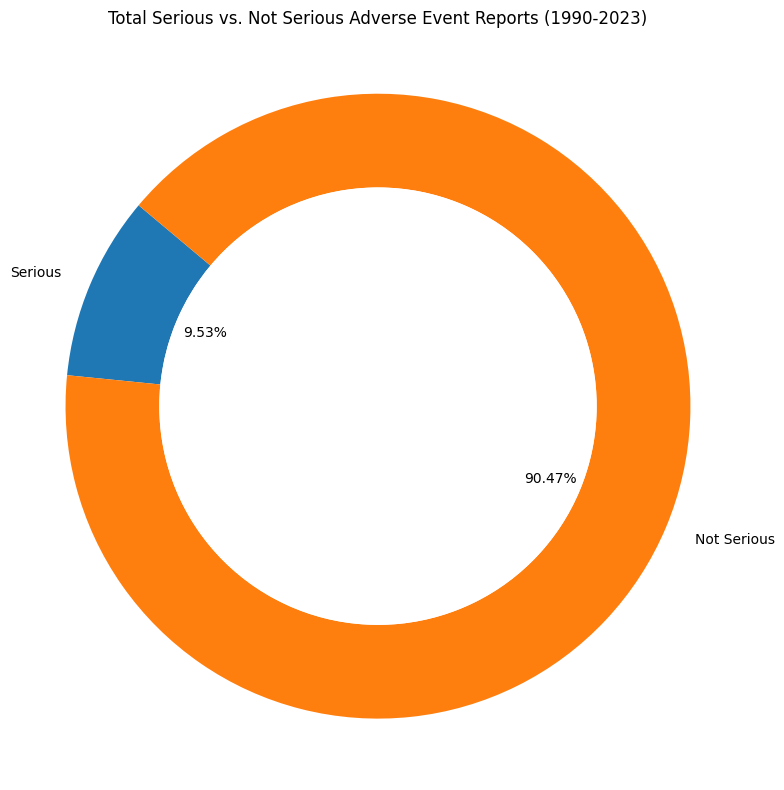

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize counters for serious and not serious reports
total_serious = 0
total_not_serious = 0

for year in range(1990, 2024):
    # Construct the file name
    filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    
    # Load the data
    data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    
    # Count serious entries (entries with 'Y' in any of the serious columns)
    serious_count = (data == 'Y').any(axis=1).sum()
    not_serious_count = len(data) - serious_count
    
    # Update the total counts
    total_serious += serious_count
    total_not_serious += not_serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Create a donut chart
plt.figure(figsize=(8, 8))
ax = plt.gca()

plt.pie(counts_df['Count'], labels=counts_df.index, autopct='%1.2f%%', startangle=140, wedgeprops={'width': 0.3})

# Add a circle at the center to make it a donut chart
center_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Total Serious vs. Not Serious Adverse Event Reports (1990-2023)')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_all_Years_Donut.png')
plt.show()


IndexError: single positional indexer is out-of-bounds

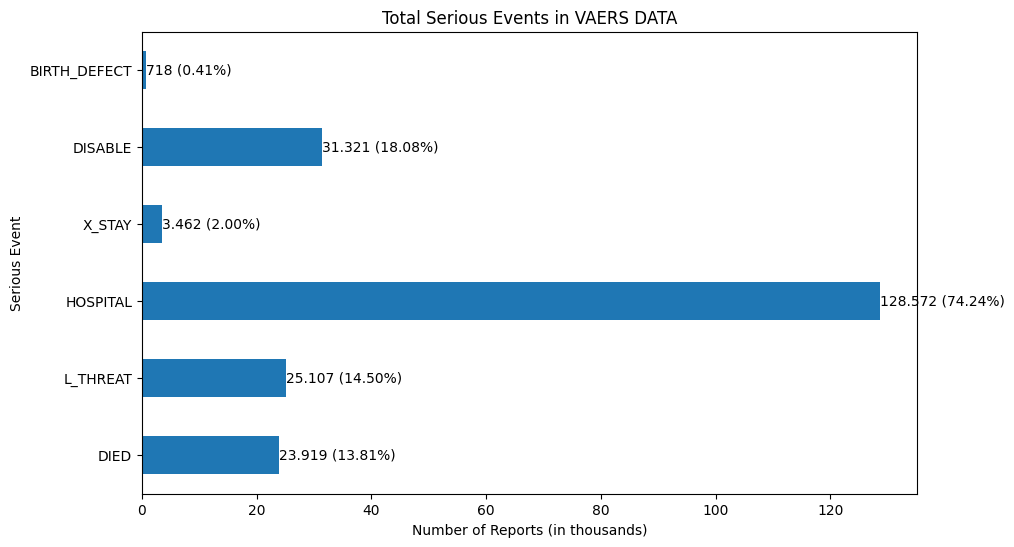

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a dictionary to store the counts for each serious event
serious_counts = {column: 0 for column in serious_columns}

# Initialize a counter for the total number of serious reports
total_serious_reports = 0

for year in range(1990, 2024):
    try:
        # Construct the file name
        filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        
        # Load the data only needed columns
        data = pd.read_csv(filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
        
        # Check if the dataset contains the specified columns
        missing_columns = set(serious_columns) - set(data.columns)
        if missing_columns:
            print(f"Warning: Missing columns in year {year}: {missing_columns}")
            continue
        
        # Count the number of "Y" values in each serious column
        for column in serious_columns:
            serious_counts[column] += (data[column] == 'Y').sum()
        
        # Count the total number of serious reports for the current year
        total_serious_reports += len(data[data[serious_columns].eq('Y').any(axis=1)])
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Create a DataFrame for plotting
serious_df = pd.DataFrame({'Count': serious_counts.values()}, index=serious_counts.keys())

# Calculate the percentage for each serious event based on the total serious reports
serious_df['Percentage'] = (serious_df['Count'] / total_serious_reports) * 100

# Plotting
plt.figure(figsize=(10, 6))
ax = serious_df[['Count', 'Percentage']].plot(kind='barh', stacked=True, legend=False, ax=plt.gca())
plt.title('Total Serious Events in VAERS DATA')
plt.xlabel('Number of Reports (in thousands)')  # Updated x-axis label
plt.ylabel('Serious Event')

# Custom function to format number with period as thousand separator
def format_with_period(number, pos=None):  # Accept pos argument even if not used
    return format(number / 1000, ",.0f").replace(",", ".")  # Divide by 1000 and format

# Create a FuncFormatter for the x-axis labels
x_formatter = FuncFormatter(format_with_period)
ax.xaxis.set_major_formatter(x_formatter)

# Annotating with counts and percentages
for idx, p in enumerate(ax.patches):
    count = int(serious_df.iloc[idx]['Count'])  # Convert to integer
    formatted_count = format_with_period(count * 1000)  # Format in thousands
    percentage = serious_df.iloc[idx]['Percentage']
    label = f"{formatted_count} ({percentage:.2f}%)"
    
    # Adjust annotation positions
    text_x = p.get_x() + p.get_width() if count > 0 else -100  # Move the text to the right of the bar
    ax.annotate(label, (text_x, p.get_y() + p.get_height() / 2.), va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_all_Years_Individual.png')
plt.show()

In [148]:
serious_df

,Count,Percentage
DIED,23919,13.810604
L_THREAT,25107,14.496544
HOSPITAL,128572,74.236257
X_STAY,3462,1.998926
DISABLE,31321,18.084449
BIRTH_DEFECT,718,0.414566


## For COVID-19 vaccines

the VAERS ID duplicates are removed before counting the serious events in the merged_df. This is done because VAERSDATA hat no duplicate VAERS IDs. So if the ID appears multiple times in VAERSVAX it would have the same data from VAERSDATA twice.

/var/folders/5g/yyzx5_551v1dz53h3hnm2nmw0000gn/T/ipykernel_36637/219637736.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y/1000):,d}' for y in yticks])


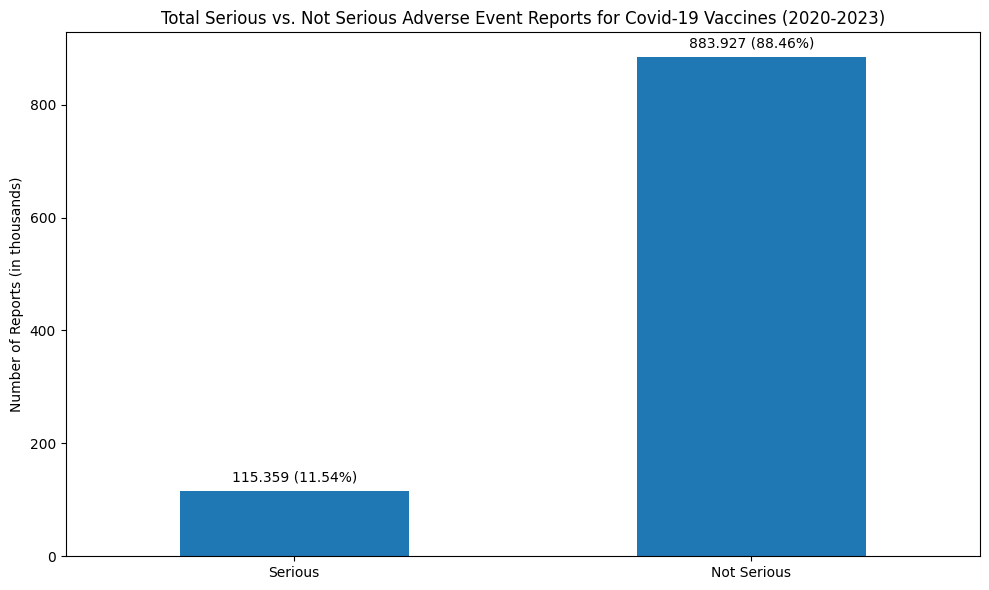

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

serious_columns = ['VAERS_ID', 'DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']
total_serious = 0
total_not_serious = 0

for year in range(2020, 2024):
    # File paths
    data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
    
    # Load datasets (only necessary columns for VAERSDATA)
    data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
    
    # Filter VAERSVAX for COVID19
    covid_vax_df = vax_df[vax_df['VAX_TYPE'].str.contains('COVID19')]
    
    # Merge datasets on VAERS_ID
    merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
    merged_df = merged_df.drop_duplicates(subset=['VAERS_ID'])
    
    # Count serious and not serious entries
    serious_count = (merged_df[serious_columns[1:]] == 'Y').any(axis=1).sum()
    total_count = len(merged_df)
    
    # Update totals
    total_serious += serious_count
    total_not_serious += total_count - serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
ax = counts_df['Count'].plot(kind='bar', legend=False, ax=plt.gca())
plt.title('Total Serious vs. Not Serious Adverse Event Reports for Covid-19 Vaccines (2020-2023)')
plt.ylabel('Number of Reports (in thousands)')
plt.xticks(rotation=0)

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", ".")

# Annotating with counts and percentages
for idx, p in enumerate(ax.patches):
    count = int(counts_df.iloc[idx]['Count'])  # Convert to integer
    formatted_count = format_with_period(count)
    label = f"{formatted_count} ({counts_df.iloc[idx]['Percentage']:.2f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Divide y-axis tick labels by 1,000
yticks = ax.get_yticks()
ax.set_yticklabels([f'{int(y/1000):,d}' for y in yticks])
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_Covid19_Vaccines.png')
plt.show()

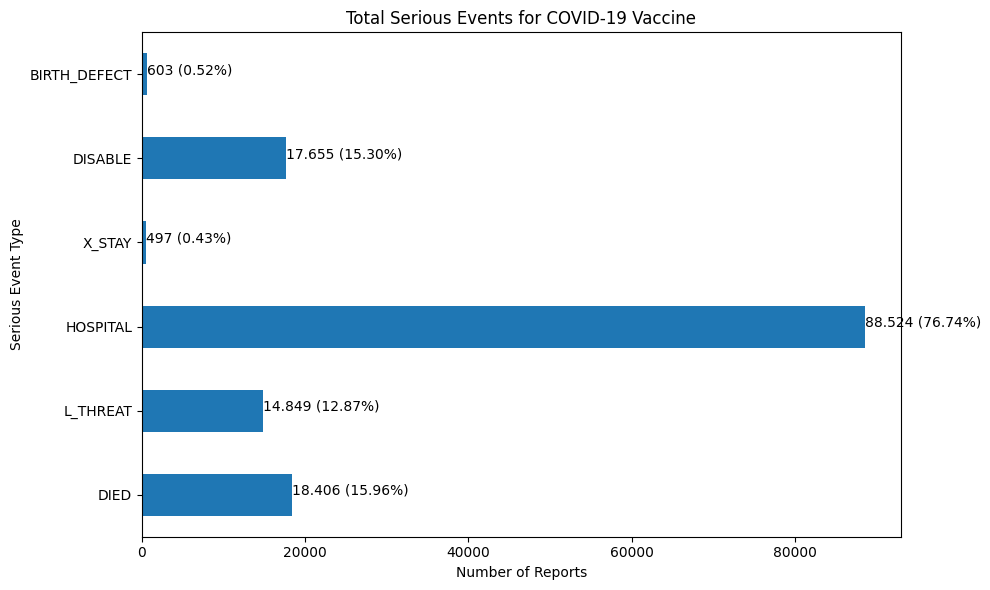

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a dictionary to store the counts for each serious event
serious_counts = {column: 0 for column in serious_columns}

# Initialize a counter for the total number of entries with any serious report for COVID19 vaccine
total_serious_reports_covid = 0

for year in range(2020, 2024):  # COVID-19 vaccines are relevant from 2020 onwards
    try:
        # Construct the file names
        data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
        
        # Load the datasets
        data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID'] + serious_columns)
        vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
        
        # Filter VAERSVAX for COVID19
        covid_vax_df = vax_df[vax_df['VAX_TYPE'].str.contains('COVID19')]

        # Merge datasets on VAERS_ID
        merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
        
                # Remove duplicates based on VAERS_ID
        merged_df = merged_df.drop_duplicates(subset=['VAERS_ID'])

        # Count the number of "Y" values in each serious column for COVID19 vaccine
        for column in serious_columns:
            serious_counts[column] += (merged_df[column] == 'Y').sum()

        # Update total serious reports for COVID19 vaccine
        total_serious_reports_covid += (merged_df[serious_columns].eq('Y').any(axis=1)).sum()

    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Create a DataFrame for plotting
serious_df = pd.DataFrame({'Count': serious_counts.values()}, index=serious_columns)

# Calculate the percentage for each serious event based on the total number of serious entries
serious_df['Percentage'] = (serious_df['Count'] / total_serious_reports_covid) * 100

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", ".")

# Plotting
plt.figure(figsize=(10, 6))
ax = serious_df['Count'].plot(kind='barh')
plt.title('Total Serious Events for COVID-19 Vaccine')
plt.xlabel('Number of Reports')
plt.ylabel('Serious Event Type')
# Annotate bars with the count and percentage
for idx, value in enumerate(serious_df['Count']):
    percentage = serious_df.loc[serious_df.index[idx], 'Percentage']
    formatted_value = format_with_period(value)
    plt.text(value, idx, f'{formatted_value} ({percentage:.2f}%)')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_Covid19_Vaccines_Individual.png')
plt.show()


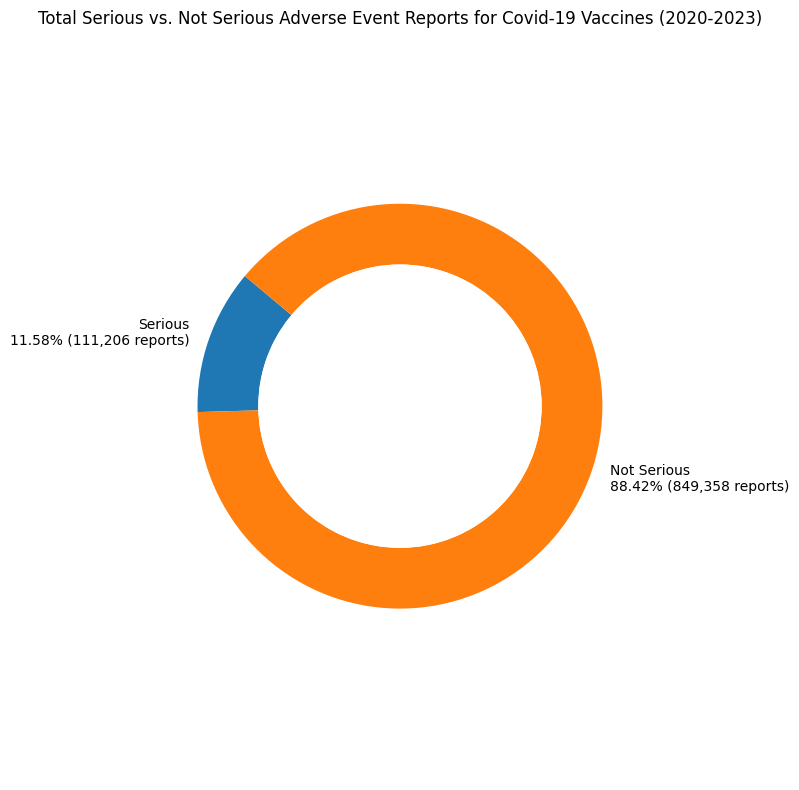

In [179]:

import pandas as pd
import matplotlib.pyplot as plt

serious_columns = ['VAERS_ID', 'DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']
total_serious = 0
total_not_serious = 0

for year in range(2020, 2024):
    # File paths
    data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
    
    # Load datasets (only necessary columns for VAERSDATA)
    data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
    
    # Filter VAERSVAX for COVID19
    covid_vax_df = vax_df[vax_df['VAX_TYPE'] == 'COVID19']
    
    # Merge datasets on VAERS_ID
    merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
    merged_df = merged_df.drop_duplicates(subset=['VAERS_ID'])
    
    # Count serious and not serious entries
    serious_count = (merged_df[serious_columns[1:]] == 'Y').any(axis=1).sum()
    total_count = len(merged_df)
    
    # Update totals
    total_serious += serious_count
    total_not_serious += total_count - serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Create a donut chart
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Combine percentage and total count in labels
labels = [f"{index}\n{counts_df['Percentage'][index]:.2f}% ({counts_df['Count'][index]:,} reports)" for index in counts_df.index]

plt.pie(counts_df['Count'], labels=labels, autopct='', startangle=140, wedgeprops={'width': 0.3})

# Add a circle at the center to make it a donut chart
center_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Total Serious vs. Not Serious Adverse Event Reports for Covid-19 Vaccines (2020-2023)')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_Covid19_Vaccines_Donut.png')
plt.show()


/var/folders/5g/yyzx5_551v1dz53h3hnm2nmw0000gn/T/ipykernel_36637/773489850.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y/1000):,d}' for y in yticks])


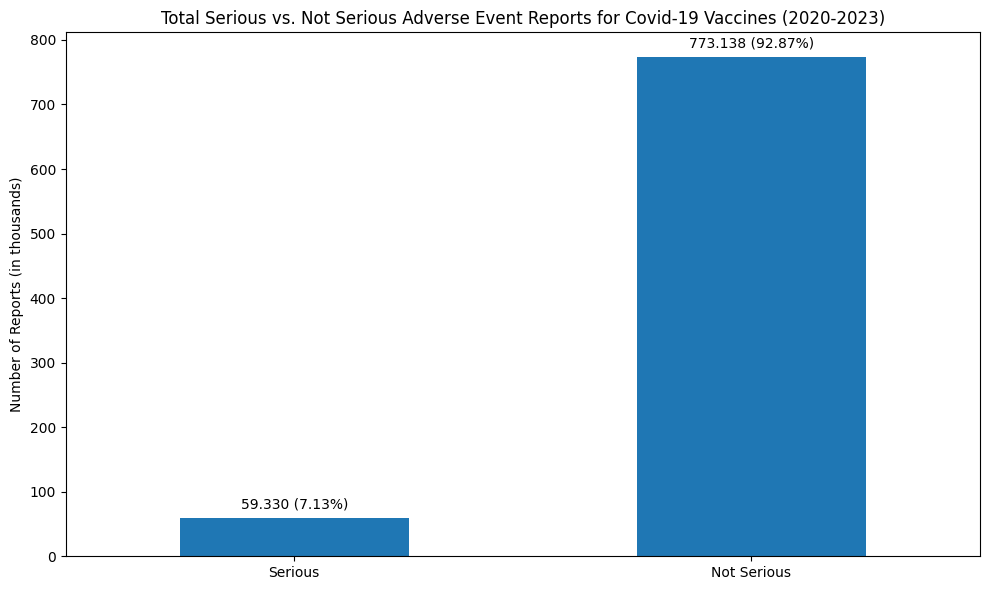

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

serious_columns = ['VAERS_ID', 'DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']
total_serious = 0
total_not_serious = 0

for year in range(1990, 2024):
    # File paths
    data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
    vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
    
    # Load datasets (only necessary columns for VAERSDATA)
    data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=serious_columns)
    vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
    
    # Filter VAERSVAX for COVID19
    covid_vax_df = vax_df[~vax_df['VAX_TYPE'].str.contains('COVID19')]
    
    # Merge datasets on VAERS_ID
    merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
    merged_df = merged_df.drop_duplicates(subset=['VAERS_ID'])
    
    # Count serious and not serious entries
    serious_count = (merged_df[serious_columns[1:]] == 'Y').any(axis=1).sum()
    total_count = len(merged_df)
    
    # Update totals
    total_serious += serious_count
    total_not_serious += total_count - serious_count

# Create a DataFrame for plotting
counts_df = pd.DataFrame({'Count': [total_serious, total_not_serious]}, index=['Serious', 'Not Serious'])

# Calculate the percentage
total_reports = total_serious + total_not_serious
counts_df['Percentage'] = (counts_df['Count'] / total_reports) * 100

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
ax = counts_df['Count'].plot(kind='bar', legend=False, ax=plt.gca())
plt.title('Total Serious vs. Not Serious Adverse Event Reports for Covid-19 Vaccines (2020-2023)')
plt.ylabel('Number of Reports (in thousands)')
plt.xticks(rotation=0)

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", ".")

# Annotating with counts and percentages
for idx, p in enumerate(ax.patches):
    count = int(counts_df.iloc[idx]['Count'])  # Convert to integer
    formatted_count = format_with_period(count)
    label = f"{formatted_count} ({counts_df.iloc[idx]['Percentage']:.2f}%)"
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Divide y-axis tick labels by 1,000
yticks = ax.get_yticks()
ax.set_yticklabels([f'{int(y/1000):,d}' for y in yticks])
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_non_Covid19_Vaccines.png')
plt.show()

# For non Covid vaccines

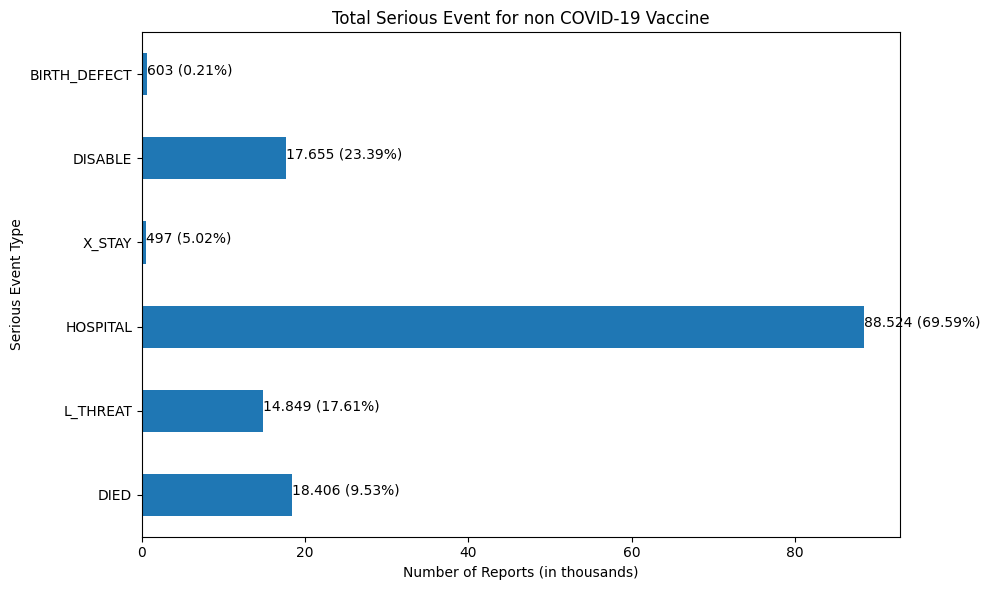

In [230]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the columns that indicate a serious report
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a dictionary to store the counts for each serious event
serious_counts = {column: 0 for column in serious_columns}

# Initialize a counter for the total number of entries with any serious report for COVID19 vaccine
total_serious_reports_covid = 0

for year in range(1990, 2024):  # COVID-19 vaccines are relevant from 2020 onwards
    try:
        # Construct the file names
        data_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        vax_filename = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
        
        # Load the datasets
        data_df = pd.read_csv(data_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID'] + serious_columns)
        vax_df = pd.read_csv(vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])
        
        # Filter VAERSVAX for COVID19
        covid_vax_df = vax_df[~vax_df['VAX_TYPE'].str.contains('COVID19')]
        

        # Merge datasets on VAERS_ID
        merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
        
                # Remove duplicates based on VAERS_ID
        merged_df = merged_df.drop_duplicates(subset=['VAERS_ID'])

        # Count the number of "Y" values in each serious column for COVID19 vaccine
        for column in serious_columns:
            serious_counts[column] += (merged_df[column] == 'Y').sum()

        # Update total serious reports for COVID19 vaccine
        total_serious_reports_covid += (merged_df[serious_columns].eq('Y').any(axis=1)).sum()

    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Create a DataFrame for plotting
serious_non_covid_df = pd.DataFrame({'Count': serious_counts.values()}, index=serious_columns)

# Calculate the percentage for each serious event based on the total number of serious entries
serious_non_covid_df['Percentage'] = (serious_non_covid_df['Count'] / total_serious_reports_covid) * 100

# Custom function to format number with period as thousand separator
def format_with_period(number):
    return format(number, ",d").replace(",", ".")

def format_in_thousands(x, pos):
    return f'{x/1000:.0f}'

# Plotting
plt.figure(figsize=(10, 6))
ax = serious_df['Count'].plot(kind='barh')
plt.title('Total Serious Event for non COVID-19 Vaccine')
plt.xlabel('Number of Reports (in thousands)')
plt.ylabel('Serious Event Type')
# Annotate bars with the count and percentage
for idx, value in enumerate(serious_df['Count']):
    percentage = serious_non_covid_df.loc[serious_non_covid_df.index[idx], 'Percentage']
    formatted_value = format_with_period(value)
    plt.text(value, idx, f'{formatted_value} ({percentage:.2f}%)')
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_in_thousands))

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_non_Covid19_Vaccines_Individual.png')
plt.show()


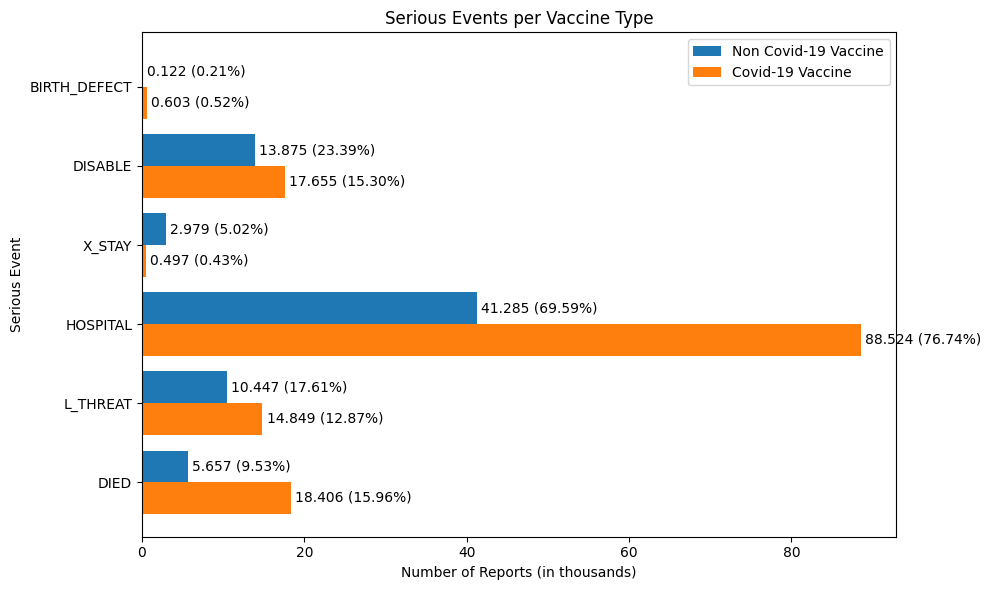

In [227]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

rows = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Number of rows
num_rows = len(rows)

# Generating positions for the bars
y = np.arange(num_rows)

# Bar width
bar_width = 0.4

# Plotting
plt.figure(figsize=(10, 6))

# Plot the bars for serious_non_covid_df on the right
plt.barh(y + bar_width/2, serious_non_covid_df["Count"], bar_width, label='Non Covid-19 Vaccine')

# Plot the bars for serious_df (Covid-19 Vaccine) on the left, below the other bars
plt.barh(y - bar_width/2, serious_df["Count"], bar_width, label='Covid-19 Vaccine')

# Set y-axis labels
plt.yticks(y, rows)

# Set x-axis labels
plt.xlabel('Number of Reports (in thousands)')  # Updated label

# Add labels and title
plt.ylabel('Serious Event')
plt.title('Serious Events per Vaccine Type')

# Add legend
plt.legend()

# Custom formatter function for x-axis in thousands
# Custom formatter function for x-axis in thousands with a dot separator for bar labels
def thousands_formatter(x, pos):
    return '{:,.0f}'.format(x/1000).replace(',', '.')  # Format as thousands with dot separator

def thousands_formatter_axis(x, pos):
    return '{:,.3f}'.format(x/1000).replace(',', '.')  # Format as thousands with dot separator

# Set x-axis formatter with dot separator for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

# Add numbers to the bars with percentage value, formatted with a dot for thousands
for i, count1, count2, pct1, pct2 in zip(y, serious_df["Count"], serious_non_covid_df["Count"],
                                         serious_df["Percentage"], serious_non_covid_df["Percentage"]):
    label1 = f'{thousands_formatter_axis(count1, 0)} ({pct1:.2f}%)'
    label2 = f'{thousands_formatter_axis(count2, 0)} ({pct2:.2f}%)'
    
    plt.text(count1 + 500, i - bar_width/2, label1, ha='left', va='center', fontsize=10)
    plt.text(count2 + 500, i + bar_width/2, label2, ha='left', va='center', fontsize=10)


# Show the plot
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_non_Covid19_Vaccines_Individual_Comparison.png')
plt.show()


In [175]:
serious_df

,Count,Percentage
DIED,5657,9.534805
L_THREAT,10447,17.608293
HOSPITAL,41285,69.585370
X_STAY,2979,5.021069
DISABLE,13875,23.386145
BIRTH_DEFECT,122,0.205630
